# Visualising Social Metrics

This notebook generates all the proxemic figures used in 
[our paper](https://doi.org/10.1145/3411764.3445729) on _Proxemics and Social 
Interactions in an Instrumented Virtual Reality Workshop_. 

## Using this Notebook, Code, or Data
This notebook and all of the resources included here are released on a 
[Mozilla Public License 2.0](https://www.mozilla.org/en-US/MPL/2.0/).  The data 
is released under [CC-BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).
To cite the paper, the bespoke logging client, the dataset, or this notebook 
please see the [README.md](https://github.com/ayman/hubs-research-2021/blob/main/README.md) 
or the [DOI in the ACM Digital Library](https://doi.org/10.1145/3411764.3445729).

## Requirements

In [1]:
import pickle
import pandas as pd
import numpy as np
import scipy
from scipy import  spatial

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

Load our past pickles and csv data.

In [2]:
with open("outputs/social_metrics.pkl", "rb") as f:
    loaded_matrices = pickle.load(f)
    
main_room = pd.read_csv('outputs/main_room_resampled_0.167.csv')
a_room = pd.read_csv('outputs/room_a_resampled_0.167.csv')
b_room = pd.read_csv('outputs/room_b_resampled_0.167.csv')
c_room = pd.read_csv('outputs/room_c_resampled_0.167.csv')

## Generating Visualisations

Will cover here were the coordinate settings come from in Spoke etc...

In [6]:
# Generate Some Plots!!! 
def draw_kde_map(df,
                 bins=50,
                 pct=1,
                 save_fig="default.png",
                 grid="assets/Outdoor Meetup.png", 
                 x_min=60,
                 x_max=-10,
                 y_min=20,
                 y_max=-20,
                 quiver=False, 
                 quiver_overlay=None):
    plt.figure()
    meetup = plt.imread(grid)
    df_clean = df.dropna()

    ys = df_clean['position_x'].values
    xs = df_clean['position_z'].values

    plt.gca().set_facecolor("#09061F")
    
    plt.yscale('linear')
    plt.xscale('linear')
    plt.ylim((y_min, y_max))
    plt.xlim((x_min, x_max))
    
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    ax = sns.kdeplot(x=xs, y=ys, cmap=plt.cm.inferno, shade=True) 
    
    plt.imshow(meetup, extent=[x_min, x_max, y_min, y_max], zorder=3)
    
    if quiver:
        overlay = plt.imread(quiver_overlay)
        plt.imshow(overlay,extent=[x_min, x_max, y_min, y_max], zorder=5)
   
    plt.savefig(save_fig, format='pdf', bbox_inches="tight", dpi=1200) 
    plt.show()

### Figure 4

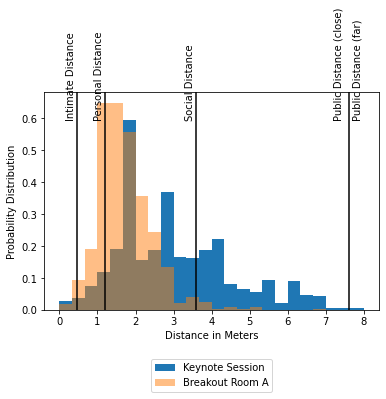

In [4]:
ks = loaded_matrices["keynote"]["mins_by_frame"][~np.isnan(loaded_matrices["keynote"]["mins_by_frame"])].flatten()
aas = loaded_matrices["a_room"]["mins_by_frame"][~np.isnan(loaded_matrices["a_room"]["mins_by_frame"])].flatten()

plt.figure()
bins = np.linspace(0, 8.0, 25)
plt.hist(ks, 
         bins=bins, 
         density=True, 
         # color="#F6E61F",
         label="Keynote Session") 
plt.hist(aas, 
         bins=bins, 
         alpha=0.5, 
         density=True, 
         # color="#4BC26C", 
         label="Breakout Room A") 
plt.xlabel("Distance in Meters")
plt.ylabel("Probability Distribution")
plt.axvline(x=.46,  c='black')
plt.axvline(x=1.2, c='black')
plt.axvline(x=3.6 , c='black')
plt.axvline(x=7.6 , c='black')
plt.text(.16, .6, "Intimate Distance", rotation=90)
plt.text(.9, .6, "Personal Distance", rotation=90)
plt.text(3.3, .6, "Social Distance", rotation=90)
plt.text(7.2, .6, "Public Distance (close)", rotation=90)
plt.text(7.7, .6, "Public Distance (far)", rotation=90)

lgd = plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))

plt.savefig('outputs/figure_4_closest_person.pdf',
            bbox_extra_artists=(lgd,),
            bbox_inches='tight',
            format='pdf',
            dpi=1200)

### Figure 5

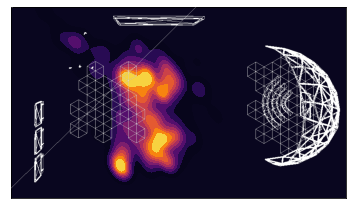

In [7]:
draw_kde_map(main_room, save_fig="outputs/overall.pdf")

## Quiver Plot

Annoyingly complicated... will brush up this code and fix rotation issue 
for quiver overlay.

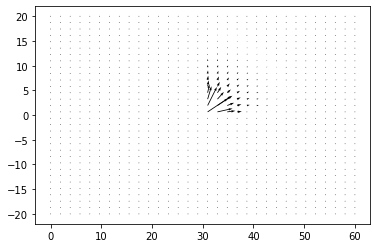

In [8]:
# Takes one person (row) and returns a flow field
# y is up
def falloff_function(x, y, z, grid, dist=1.0, exp=2.0):
    # distance falloff only
    vx = grid[0] - x
    vz = grid[1] - z
    return 1.0/(np.sqrt((vx**2 + vz**2)/dist)**exp+1)

def angular_cone(x,y,z,dx,dy,dz,grid,fov=80):
    vx = grid[0] - x
    vz = grid[1] - z
    vnorm = np.linalg.norm(np.stack([vx, vz]), axis=0)
    vx = vx/vnorm
    vz = vz/vnorm
    dnorm = np.sqrt(dx**2 + dz**2)
    dx_norm = dx / dnorm
    dz_norm = dz / dnorm
    grid_angle = np.arctan2(vx, vz)
    angular_difference = grid_angle - np.arctan2(dx_norm, dz_norm)
    angular_difference = np.minimum((2 * np.pi) - np.abs(angular_difference),
                                    np.abs(angular_difference))
    
    cone = np.where(abs(angular_difference)>np.radians(fov/2), 0, 1)
    return (vx*cone, vz*cone)

resolution = 32
# sets the range for the grid
mx, mz = np.meshgrid(np.linspace(0, 60, resolution), 
                     np.linspace(-20, 20, resolution))

falloff = falloff_function(30, 0.0, 0.0, (mx, mz), dist=7.6)

plt.figure()
# plt.pcolor(mx, mz, falloff)
dot_product = angular_cone(30, 0.0, 0.0, 0.7, 0.0, 0.7, (mx, mz), fov=80) 
plt.quiver(mx, 
           mz, 
           dot_product[0] * falloff, 
           dot_product[1] * falloff, 
           scale=10)

In [10]:
def frame_field(frame, grid, falloff_distance=50, fov=80):
    accumulator = np.zeros_like(grid[0]), np.zeros_like(grid[1])
    for ix, uuid in frame.iterrows():
        flow = person_flow_field(uuid.position_x, 
                                 uuid.position_y, 
                                 uuid.position_z, 
                                 uuid.direction_x, 
                                 uuid.direction_y, 
                                 uuid.direction_z,
                                 grid, 
                                 falloff_distance, 
                                 fov)
        
        plt.plot(uuid.position_x, uuid.position_z, 'r.')
        
        accumulator[0][:] += flow[0]
        accumulator[1][:] += flow[1]
    # average flow for one frame
    return accumulator[0] / len(frame), accumulator[1]/len(frame)

# Takes a sequence of frames and returns an average flow field
def frame_sequence_field(df,
                         resolution,
                         x_min,
                         x_max,
                         z_min,
                         z_max,
                         falloff_distance=50,
                         fov=80):
    # sets the range for the grid
    mx, mz = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(z_min, z_max, resolution))
    grid = (mx, mz)
    accumulator = np.zeros_like(grid[0]), np.zeros_like(grid[1])
    n_frames = 0
    for frame_id, frame in df.groupby("frame_id"):
        # print(f"Frame {n_frames} {frame_id}")
        flow = frame_field(frame, grid, falloff_distance, fov)
        n_frames += 1
        accumulator[0][:] += flow[0]
        accumulator[1][:] += flow[1]
    # average flow for one frame
    return (grid[0], 
            grid[1], 
            accumulator[0] / n_frames, 
            accumulator[1] / n_frames)

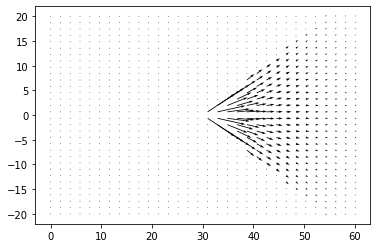

In [11]:
def person_flow_field(x, y, z, 
                      dx, dy, dz, 
                      grid, falloff_distance=50, fov=80):
    falloff = falloff_function(x, y, z, grid, dist=falloff_distance)
    cone = angular_cone(x, y, z, dx, dy, dz, grid, fov=fov) 
    return falloff * cone

flow = person_flow_field(30.0, 0.0, 0.0, 1.0, 0.0, 0.0, (mx, mz), fov=80)
plt.figure()
plt.quiver(mx, mz, flow[0], flow[1], scale=10)
# One frame and returns an average flow field

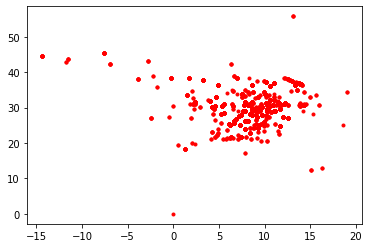

In [12]:
plt.figure()
x, z, u, v = frame_sequence_field(loaded_matrices["keynote"]["slice"],
                                  32, -20, 20, -10, 60,
                                  falloff_distance=7.6,
                                  fov=80)

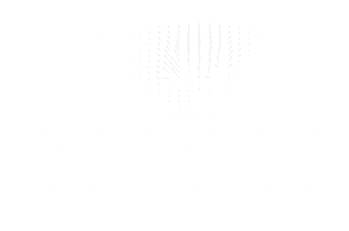

In [13]:
fig, ax = plt.subplots()
plt.quiver(z, x,  v, u, scale=1.5, color="#f0f2f1")
plt.axis("equal")

ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis("off")

fig.savefig('outputs/quiver_overlay.png', 
            format='png', 
            bbox_inches="tight", 
            dpi=1200, 
            transparent=True)
# Note: This figure is very light because we will overlay it in the Figure 6 step.

### Figure 6

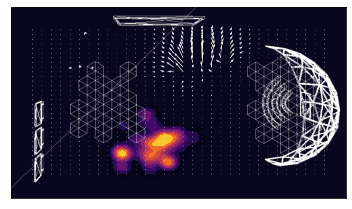

In [14]:
draw_kde_map(loaded_matrices["keynote"]["slice"], 
             save_fig="outputs/figure_6_keynote_quiver.pdf", 
             quiver=True, 
             quiver_overlay="outputs/quiver_overlay.png")

### Figure 7

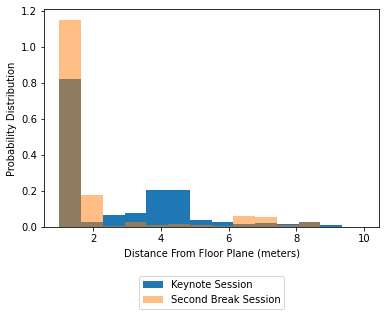

In [15]:
k_ys = loaded_matrices["keynote"]["slice"].position_y
b_ys = loaded_matrices["break_2"]["slice"].position_y

plt.figure()
bins = np.linspace(1, 10, 15)
plt.hist(k_ys,
         bins=bins,
         density=True,
         label="Keynote Session")
plt.hist(b_ys,
         bins=bins,
         alpha=0.5,
         density=True,
         # color="#4BC26C",
         label="Second Break Session")

plt.xlabel("Distance From Floor Plane (meters)")
plt.ylabel("Probability Distribution")
lgd = plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4))
plt.savefig('outputs/figure_7_offTheFloor.pdf',
            bbox_extra_artists=(lgd,),
            bbox_inches='tight',
            format='pdf',
            dpi=1200)

### Paper Figure 8

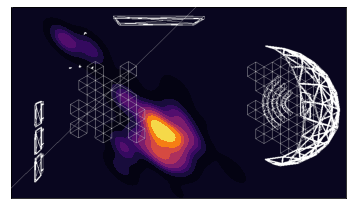

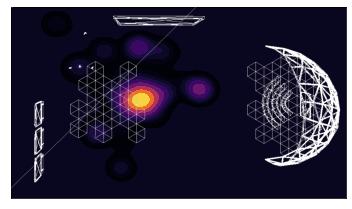

In [16]:
draw_kde_map(loaded_matrices["break_1"]["slice"],
             save_fig="outputs/figure_8_break1.pdf")
draw_kde_map(loaded_matrices["break_2"]["slice"],
             save_fig="outputs/figure_8_break2.pdf")